In [41]:
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from toolz import partial
from os.path import join
from scipy import stats, signal
from collections import defaultdict
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.plotting import add_legend, save_factory
from rl_analysis.photometry.windowing import window_trials_as_df
from rl_analysis.plotting import setup_plotting_env, clean_ticks, COLORS, fg
from rl_analysis.photometry.signal import rereference, peak_indices, rolling_fluor_normalization

In [16]:
def filter_signal(v):
    sos = signal.butter(2, 3, output="sos", fs=30.)
    f = signal.sosfiltfilt(sos, v)
    return f

In [6]:
ts_scale = 1.25e-4

In [7]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

## Find peaks, compare stim trials to spontaneous dLight

In [33]:
dff_func = partial(rolling_fluor_normalization, window_size=5, quantile=0.1, normalizer="dff")
z_func = partial(rolling_fluor_normalization, window_size=20, normalizer='zscore')

In [8]:
setup_plotting_env()
saver = save_factory(join(config['figures']['dir_wg'], 'fig-03'), tight_layout=False)

In [12]:
random_stims = sorted(
    glob(
        "/home/wg41/groups/win/raw-reinforcement-data/realtime_stimulation_arhmm_photometry_02/realtime_stimulation_arhmm_photometry_02/session_20210208*/photometry_df.parquet"
    )
)

paths = [
    *random_stims,
    "/home/wg41/groups/win/reinforcement-data/dlight-random-stim-test/session_20210202184947-067904 (datta-realtime1)/photometry_df.parquet",
    "/home/wg41/groups/win/reinforcement-data/dlight-random-stim-test/session_20210202175937-380105 (datta-realtime1)/photometry_df.parquet",
]

In [34]:
data = defaultdict(list)
truncation_window = (-1.5, 1.5)
fps = 30

for df_path in paths:
    ts = np.loadtxt(df_path.replace("photometry_df.parquet", "depth_ts.txt"))
    ts *= ts_scale

    fb = np.loadtxt(df_path.replace("photometry_df.parquet", "feedback_ts.txt"))[:, 0]
    fb *= ts_scale
    fb -= ts[0]

    df = pd.read_parquet(df_path)
    df["signal_dff"] = dff_func(df["pmt00_ref00 (dLight)"])
    df["reference_dff"] = dff_func(df["pmt00_ref01"])
    nans = df["signal_dff"].isna()
    df["dlight_reref_dff"] = df.loc[~nans].transform(
        lambda x: rereference(
            filter_signal(x["reference_dff"]), x["signal_dff"], center=False, clip=False
        )
    )["rereference"]
    df['dlight_reref_dff'] = z_func(df['dlight_reref_dff'])

    df["feedback_status"] = -1

    for ind in fb:
        df.loc[df["timestamp"] == ind, "feedback_status"] = 1

    inds = np.where(df["feedback_status"] == 1)[0]

    _, stim_df = window_trials_as_df(
        df, inds, "dlight_reref_dff", "feedback_status", truncation_window=(0, 0.6)
    )
    stim_peaks = stim_df.groupby("trials")["dlight"].max()
    data["stim_peaks"].append(stim_peaks)

    for i, ind in enumerate(inds):
        x = df.iloc[ind:ind + int(0.6 * fps)]["dlight_reref_dff"]
        m = x.argmax()
        inds[i] = ind + m

    _, stim_df = window_trials_as_df(
        df,
        inds,
        "dlight_reref_dff",
        "feedback_status",
        truncation_window=truncation_window,
    )
    data["stim_waveforms"].append(stim_df)

    # find peaks not associated with stimulation
    ns = peak_indices(df["dlight_reref_dff"], thresh=stim_peaks.quantile(0.25))
    _, nonstim_df = window_trials_as_df(
        df,
        ns,
        "dlight_reref_dff",
        "feedback_status",
        truncation_window=truncation_window,
    )
    peaks = nonstim_df.query("time == 0")
    data["spont_peaks"].append(peaks["dlight"])
    data["spont_waveforms"].append(nonstim_df)

    filtered_peaks = peaks[peaks["dlight"].between(*stim_peaks.quantile([0.25, 0.75]))]

    data["spont_thresholded_peaks"].append(peaks["dlight"])

    filtered_df = nonstim_df[nonstim_df["trials"].isin(filtered_peaks["trials"])]
    data["spont_thresholded_waveforms"].append(filtered_df)

In [35]:
pctiles = [stats.percentileofscore(np.concatenate(data['spont_peaks']), x) for x in np.concatenate(data['stim_peaks'])]

In [36]:
_min = np.min(np.concatenate(data['stim_peaks'] + data['spont_peaks']))

In [58]:
# fraction of maximum spontaneous peak
max_frac = (np.concatenate(data["stim_peaks"]) - _min) / np.percentile(
    np.concatenate(data["spont_peaks"]) - _min, 99
)

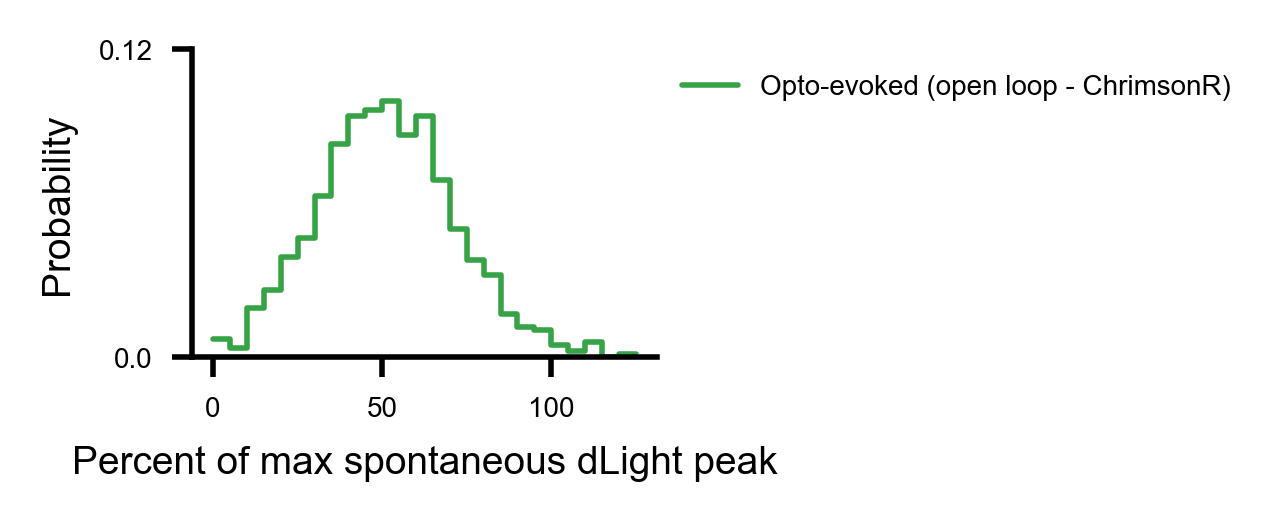

In [57]:
fig = fg(1.5, 1)
fig.dpi = 200
ax = sns.histplot(
    max_frac * 100,
    color=COLORS["green"],
    element="step",
    linewidth=1,
    binwidth=5,
    fill=False,
    stat="probability",
    label="Opto-evoked (open loop - ChrimsonR)",
)
sns.despine()
ax.set(ylim=(0, 0.12), xticks=[0, 50, 100])
clean_ticks(ax, axis="y", zero_symmetry=False, precision=2)
add_legend(ax)
plt.xlabel("Percent of max spontaneous dLight peak")
saver(fig, "open-loop-fraction-of-spontaneous-histplot");

In [47]:
np.concatenate(data['stim_peaks']).mean()

2.1808932093037052

In [48]:
np.concatenate(data['stim_peaks']).std()

0.8534845042270296

In [49]:
np.concatenate(data['spont_peaks']).mean()

2.226527094602974

In [50]:
np.concatenate(data['spont_peaks']).std()

0.6199986438832136

In [51]:
np.concatenate(data['spont_thresholded_peaks']).mean()

2.226527094602974

In [52]:
np.concatenate(data['spont_thresholded_peaks']).std()

0.6199986438832136

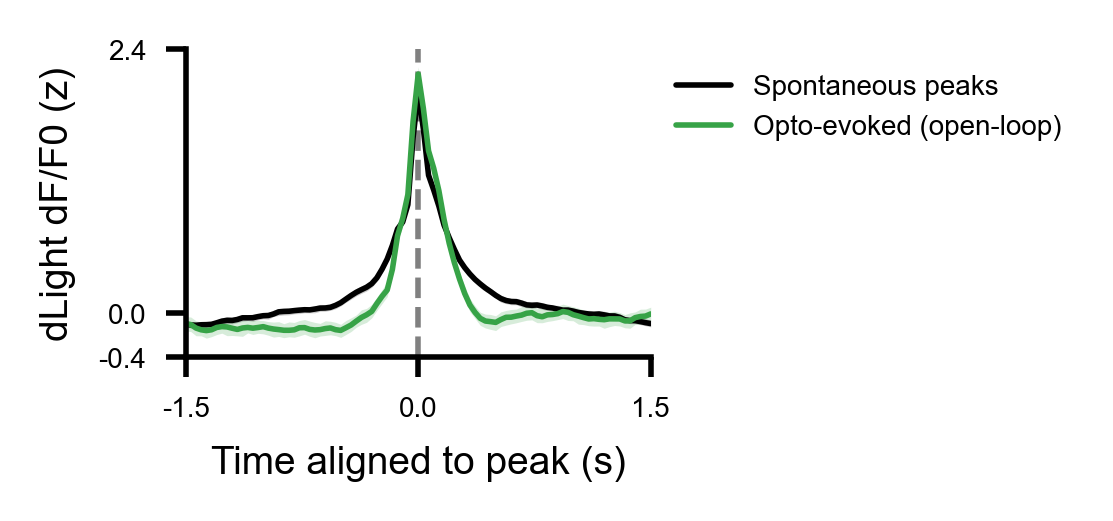

In [55]:
fig = fg(1.5, 1)
fig.dpi = 200

ax = sns.lineplot(
    data=pd.concat(data["spont_thresholded_waveforms"], ignore_index=True),
    x="time",
    y="dlight",
    color="k",
    linewidth=1,
    label="Spontaneous peaks",
    err_kws=dict(linewidth=0),
    n_boot=200,
)

sns.lineplot(
    data=pd.concat(data["stim_waveforms"], ignore_index=True),
    x="time",
    y="dlight",
    label="Opto-evoked (open-loop)",
    color=COLORS['green'],
    linewidth=1,
    err_kws=dict(linewidth=0),
    n_boot=200,
)

sns.despine()

plt.xlim(-1.5, 1.5)
plt.ylabel("dLight dF/F0 (z)")
plt.xlabel("Time aligned to peak (s)")

add_legend(ax)
clean_ticks(ax, axis="y", zero_symmetry=False, precision=1)
clean_ticks(ax, axis="x", zero_symmetry=False, precision=1)

plt.axvline(0, color="gray", linestyle="--", linewidth=1, zorder=-5)
saver(fig, "dlight-vs-spontaneous-open-loop-waveforms");